In [1]:
import pandas as pd
import numpy as np
import psycopg2
import datetime
import matplotlib.pyplot as plt
import math
from scipy import stats

In [2]:
USERNAME = 'dryu'
PWD = 'VRyrf4cXDtccxT4b'
DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
           ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
          ,('verizon','rr.verizon.amer-ignite.digitalturbine.com')]
app_id = 'com.hsn.android'

In [6]:
df_installs = pd.read_csv('files/hsn_installs.csv', low_memory=False)
# df_events = pd.read_csv('files/Lyft_events.csv', low_memory=False)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/daniel.ryu/Downloads/hsn_installs.csv'

In [4]:
df_installs = df_installs.drop('timestamp', axis=1).join(df_installs['timestamp'].apply(pd.to_numeric, errors='coerce'))
print(str(df_installs['timestamp'].isna().sum()), 'invalid timestamps!')
df_installs['timestamp'] = pd.to_datetime(df_installs['timestamp'], unit='ms').astype('datetime64[ns, Europe/Paris]').dt.tz_convert('EST')
df_installs.dtypes

1 invalid timestamps!


referrer                      object
aaid                          object
appIdentifier                 object
timestamp        datetime64[ns, EST]
dtype: object

In [6]:
df = df_installs
df = df[['referrer','aaid','appIdentifier','timestamp']]
df.columns = ['referrer_install','aaid','appid','timestamp_install']
df.dtypes

referrer_install                  object
aaid                              object
appid                             object
timestamp_install    datetime64[ns, EST]
timestamp_event      datetime64[ns, EST]
dtype: object

In [7]:
df['DT_install'] = df['referrer_install'].str.contains('APPIA', na=False)
# df = df[(df['timestamp_event'] >= df['timestamp_install']) | (df['timestamp_event'].isna())]

install_start_dt = min(df.loc[(df.referrer_install.str.contains('APPIA', na=False)) 
                            & (~df.referrer_install.str.contains('APPIAOS', na=False))
                            ,'timestamp_install']).date().strftime('%Y-%m-%d')
install_end_dt = max(df.loc[df.referrer_install.str.contains('APPIA', na=False),'timestamp_install']).date().strftime('%Y-%m-%d')
print(install_start_dt, install_end_dt)

2021-03-22 2021-04-28


In [8]:
by_attribution = df.groupby('DT_install')[['timestamp_install','timestamp_event']].count()
by_attribution['event_rate'] = by_attribution['timestamp_event']/by_attribution['timestamp_install']
by_attribution

timestamp_install  timestamp_event  event_rate
DT_install                                                
False                   54042              322    0.005958
True                    21944                0    0.000000

In [3]:
conn_olympus = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                                f"dbname={DB_HOST[0][0]} host={DB_HOST[0][1]}")
conn_atlas = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                              f"dbname={DB_HOST[1][0]} host={DB_HOST[1][1]}")
cur_olympus = conn_olympus.cursor()
cur_atlas = conn_atlas.cursor()


In [4]:
install_start_dt = '2021-03-22'
install_end_dt = '2021-04-28'

In [5]:
query_preload = """
    select
        aaid
        , preload_type
        , t.site_name
        , t.site_id
        , carrier
        , tracking_time as timestamp_preload
        , case when device_app_preloads > 0 then 'test' else 'control' end as test_audience
    from
    (
        select 
            ctp.advertising_id as aaid 
            , tracking_time
            , case when android_package_name = '{app_id}' then 1 else 0 end as is_app_preload
            , ctp.site_id
            , max(s.site_name) as site_name
            , case when site_name like '%AppSelect%' then 'AppSelect' else 'Silent' end as preload_type
            , max(pi.partner_name) as carrier
            , sum(count(case when android_package_name = '{app_id}' then 1 else NULl end)) 
                over (partition by ctp.advertising_id) as device_app_preloads
        from rawdata.campaign_tracking_preload ctp 
        join (
            select
                date(tracking_time) as preload_dt
                , site_id
            from rawdata.campaign_tracking_preload
                where android_package_name = '{app_id}'    
                and date(tracking_time) >= date('{start_dt}')
                and date(tracking_time) <= date('{end_dt}')
            group by 1,2
        ) app
            on ctp.site_id = app.site_id
            and date(ctp.tracking_time) = app.preload_dt
        join rawdata.site s 
            on ctp.site_id = s.site_id
        left join rawdata.partner_information pi 
            on s.partner_id = pi.partner_id
        where 
            date(tracking_time) >= date('{start_dt}')
            and date(tracking_time) <= date('{end_dt}')
        group by 1,2,3,4,6
    ) t
    where
        (device_app_preloads > 0 and is_app_preload = 1) --is test device, and is a test app preload
        or (device_app_preloads = 0 and is_app_preload = 0) --is control device, and is non-test-app preload
    group by 1,2,3,4,5,6,7
"""

In [6]:
df_preload_list = []
for dt in pd.date_range(start = install_start_dt, end = install_end_dt, freq = '7D'):
    start_dt = dt.strftime('%Y-%m-%d')
    end_dt = min(install_end_dt, (dt + datetime.timedelta(days = 6)).strftime('%Y-%m-%d'))
    print('Running date range',start_dt,'to',end_dt)
    cur_atlas.execute(query_preload.format(start_dt = start_dt, end_dt = end_dt, app_id = app_id))
    df_sub = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])
    df_preload_list.append(df_sub)

Running date range 2021-03-22 to 2021-03-28
Running date range 2021-03-29 to 2021-04-04
Running date range 2021-04-05 to 2021-04-11
Running date range 2021-04-12 to 2021-04-18
Running date range 2021-04-19 to 2021-04-25
Running date range 2021-04-26 to 2021-04-28


In [7]:
df_preload = pd.concat(df_preload_list)
df_preload['timestamp_preload'] = df_preload.timestamp_preload.astype('datetime64[ns, EST]')

#filter date range
filters = (df_preload.timestamp_preload.dt.date >= pd.to_datetime(install_start_dt)) & (df_preload.timestamp_preload.dt.date <= datetime.date.today() - datetime.timedelta(days = 1)) 
df_preload_filtered = df_preload[filters]
df_preload_filtered[['aaid','site_name','carrier','timestamp_preload','test_audience']].to_csv(f'~/Downloads/HSN_test_control_preloads_{str(install_start_dt)}_{str(install_end_dt)}.csv', index = False)



In [8]:
print('Control/Test # of Unique Preloads:',df_preload_filtered.loc[df_preload_filtered.test_audience == 'control','aaid'].nunique(),df_preload_filtered.loc[df_preload_filtered.test_audience == 'test','aaid'].nunique())

Control/Test # of Unique Preloads: 1141010 220218


In [14]:
df_merged = pd.merge(df,df_preload_filtered,left_on = 'aaid',right_on = 'aaid')

# install between 0 and 30 days since preload/notification (only keep preloads with installs)
df_merged = df_merged[((df_merged.timestamp_install - df_merged.timestamp_preload).dt.days <= 30)
                     & ((df_merged.timestamp_install - df_merged.timestamp_preload).astype('timedelta64[s]') >= 0)]

# events happening after install (99.5%) or no event for this install
# df_merged = df_merged[((df_merged.timestamp_event - df_merged.timestamp_install).astype('timedelta64[s]') >= 0) 
#                      | (df_merged.timestamp_event.isna())]

df_merged

referrer_install  \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3                                               NaN   
4                                               NaN   
...                                             ...   
101540  APPIA99892345510859133411783930160953865196   
101541  APPIA99915454053742352007965578795749171228   
101542  APPIA99924949579005115688212038370905791169   
101543  APPIA99941890347159494357951189311383290657   
101544  APPIA99996875259341825620254033917717894969   

                                        aaid            appid  \
0       0004b065-6214-4c2a-a4ca-7e6f0edfb412  com.hsn.android   
1       0004b4ac-eb1c-4183-b7ad-3621ed5dadac  com.hsn.android   
2       0005e357-ac4f-44de-90f0-d377cd27e68c  com.hsn.android   
3       000beeea-ff77-4bb1-ae63-0da52599797c  com.hsn.android   
4       00141097-1c73-4a4d-9704-36a078375d34  com.hsn.android   
...                                      ...              ...   
101540  93597cc9-6919-4a13-8db2-95938cf203c6  com.hsn.android   
101541  fa62296f-4541-4bee-bedf-480b1bbdc3e4  com.hsn.android   
101542  2b2a579a-0989-49b8-b290-0162a161241c  com.hsn.android   
101543  2aab1c0c-0119-4633-b560-4148b902deb8  com.hsn.android   
101544  ab446cb3-3b76-4c44-99c2-20da2b480a8e  com.hsn.android   

                         timestamp_install timestamp_event  DT_install  \
0      2021-04-26 19:36:35.896999936-05:00             NaT       False   
1      2021-04-11 03:32:47.145999872-05:00             NaT       False   
2         2021-04-22 15:47:08.912000-05:00             NaT       False   
3      2021-04-30 20:31:55.024999936-05:00             NaT       False   
4      2021-03-26 13:20:54.635000064-05:00             NaT       False   
...                                    ...             ...         ...   
101540    2021-04-07 12:09:01.940000-05:00             NaT        True   
101541 2021-04-14 12:42:44.991000064-05:00             NaT        True   
101542 2021-04-10 00:01:45.987000064-05:00             NaT        True   
101543 2021-04-22 16:19:56.329999872-05:00             NaT        True   
101544 2021-04-01 03:24:44.387000064-05:00             NaT        True   

       preload_type                                          site_name  \
0            Silent  DT - Verizon - US - Ignite - LG - Velvet 5G - ...   
1            Silent  DT - Cricket - US - Ignite - LG - Stylo 6 - LM...   
2            Silent  DT - Cricket - US - Ignite - Nokia - C5 Endi -...   
3            Silent  DT - Cricket - US - Ignite - LG - Escape Plus ...   
4            Silent  DT - Cricket - US - Ignite - Motorola - G Styl...   
...             ...                                                ...   
101540       Silent  DT - Cricket - US - Ignite - LG - Stylo 5 - LM...   
101541       Silent  DT - Verizon - US - Ignite - Samsung - Tab A4S...   
101542       Silent  DT - Cricket - US - Ignite - LG - Stylo 5 - LM...   
101543       Silent  DT - Cricket - US - Ignite - Nokia - C5 Endi -...   
101544       Silent      DT - Verizon - US - Ignite - LG G7 - LMG710VM   

       site_id         timestamp_preload test_audience  
0        12121 2021-03-28 07:59:35-05:00          test  
1        11960 2021-03-25 08:37:44-05:00          test  
2        11922 2021-04-13 12:39:39-05:00          test  
3        11408 2021-04-04 11:17:01-05:00          test  
4        12376 2021-03-26 09:00:30-05:00       control  
...        ...                       ...           ...  
101540   11190 2021-04-06 09:00:26-05:00          test  
101541   11847 2021-04-13 10:00:10-05:00          test  
101542   11190 2021-04-09 19:42:31-05:00          test  
101543   11922 2021-04-18 09:53:53-05:00          test  
101544   10924 2021-03-30 23:41:27-05:00          test  

[97132 rows x 11 columns]

(0.0, 0.5)

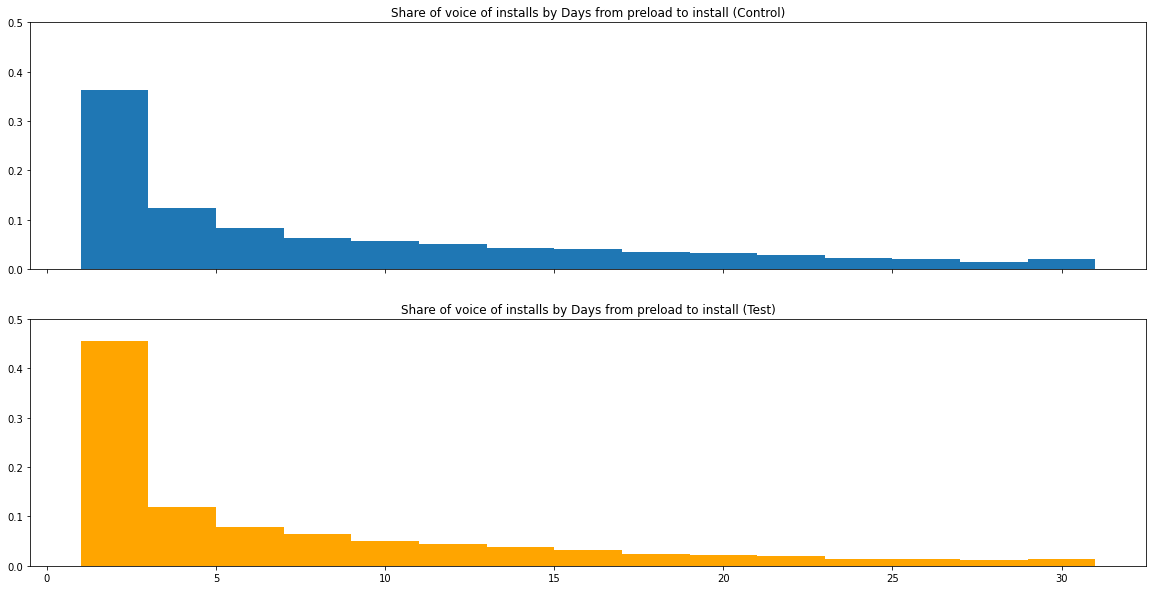

In [15]:
df_merged['preload_to_install'] = np.ceil((df_merged['timestamp_install'] - df_merged['timestamp_preload']).dt.total_seconds()/86400.)

fig, ax = plt.subplots(2,1, figsize = (20,10), sharex = True)

preload_to_install_control = df_merged.loc[(~df_merged['preload_to_install'].isna()) & (df_merged.test_audience == 'control'), 'preload_to_install']
preload_to_install_test = df_merged.loc[(~df_merged['preload_to_install'].isna()) & (df_merged.test_audience == 'test'), 'preload_to_install']
bins = 15

ax[0].hist(preload_to_install_control, bins = bins, weights=np.ones(len(preload_to_install_control)) / len(preload_to_install_control))
ax[0].set_title('Share of voice of installs by Days from preload to install (Control)')
ax[0].set_ylim(0,.5)
ax[1].hist(preload_to_install_test, bins = bins, color = 'orange', weights=np.ones(len(preload_to_install_test)) / len(preload_to_install_test))
ax[1].set_title('Share of voice of installs by Days from preload to install (Test)')
ax[1].set_ylim(0,.5)

In [26]:
# need to pivot by device in order to count only unique installs/events
# simple "count" will double-count installs and events, but we will dedupe for unique installs/events next cell
df_by_device = df_merged.pivot_table(values = ['timestamp_install'], index = ['test_audience','aaid'], aggfunc = 'count')
df_by_device.reset_index(inplace = True)
control_df = df_by_device.loc[df_by_device.test_audience == 'control', 'aaid']
control_df.to_csv(f'~/Downloads/HSN_control_{install_start_dt}_{install_end_dt}.csv', index = False)
test_df = df_by_device.loc[df_by_device.test_audience == 'test', 'aaid']
test_df.to_csv(f'~/Downloads/HSN_test_{install_start_dt}_{install_end_dt}.csv', index = False)
df_by_device

test_audience                                  aaid  timestamp_install
0           control  00141097-1c73-4a4d-9704-36a078375d34                 19
1           control  001fadad-1b59-4681-8a10-1c8aacdd6faf                 19
2           control  00489f0a-0142-41d9-93bf-9390442c0938                  9
3           control  004c5134-a910-4381-b1b0-907c903670dd                 19
4           control  0052ce0f-f69f-4c18-af11-a6c462ce2aea                 19
...             ...                                   ...                ...
35660          test  fff83a33-7faf-4a78-82b3-7618c219c5e6                  1
35661          test  fffa8258-4990-43ef-b001-8ac0f9c00e2f                  1
35662          test  fffc7784-a80c-405b-9d39-cfccc3094596                  1
35663          test  ffff18c5-82a9-42b5-b229-670b8ac7d781                  1
35664          test  ffff73b0-a24a-49b5-a41a-de76f7bc9def                  1

[35665 rows x 3 columns]

In [27]:
df_audience = df_by_device.pivot_table(values = ['timestamp_install'], index = 'test_audience', aggfunc = lambda x:(x>0).sum())
df_audience.columns = ['u_installs']
df_preload_audience = df_preload_filtered.pivot_table(values = 'aaid', index = ['test_audience'], aggfunc = pd.Series.nunique)
df_preload_audience.columns = ['u_preloads']
final_pivot = df_preload_audience.join(df_audience,how = 'left')
final_pivot['u_install_rate'] = final_pivot['u_installs']/final_pivot['u_preloads']
final_pivot[['u_preloads','u_installs','u_install_rate']]

u_preloads  u_installs  u_install_rate
test_audience                                        
control           1141010        3916        0.003432
test               220218       31749        0.144171

In [28]:
# need to pivot by device in order to count only unique installs/events
# simple "count" will double-count installs and events, but we will dedupe for unique installs/events next cell
df_by_device_site_type = df_merged.pivot_table(values = ['timestamp_install'], index = ['test_audience','preload_type','aaid'], aggfunc = 'count')
df_by_device_site_type

timestamp_install
test_audience preload_type aaid                                                   
control       Silent       00141097-1c73-4a4d-9704-36a078375d34                 19
                           001fadad-1b59-4681-8a10-1c8aacdd6faf                 19
                           00489f0a-0142-41d9-93bf-9390442c0938                  9
                           004c5134-a910-4381-b1b0-907c903670dd                 19
                           0052ce0f-f69f-4c18-af11-a6c462ce2aea                 19
...                                                                            ...
test          Silent       fff83a33-7faf-4a78-82b3-7618c219c5e6                  1
                           fffa8258-4990-43ef-b001-8ac0f9c00e2f                  1
                           fffc7784-a80c-405b-9d39-cfccc3094596                  1
                           ffff18c5-82a9-42b5-b229-670b8ac7d781                  1
                           ffff73b0-a24a-49b5-a41a-de76f7bc9def                  1

[35665 rows x 1 columns]

In [29]:
df_audience_site_type = df_by_device_site_type.pivot_table(values = ['timestamp_install','timestamp_event'], index = ['preload_type','test_audience'], aggfunc = lambda x:(x>0).sum())
df_audience_site_type.columns = ['u_events','u_installs']
df_preload_audience_site_type = df_preload_filtered.pivot_table(values = 'aaid', index = ['preload_type','test_audience'], aggfunc = pd.Series.nunique)
df_preload_audience_site_type.columns = ['u_preloads']
final_pivot_site_type = df_preload_audience_site_type.join(df_audience_site_type,how = 'left')
final_pivot_site_type['u_install_rate'] = final_pivot_site_type['u_installs']/final_pivot_site_type['u_preloads']
final_pivot_site_type['u_preload_event_rate'] = final_pivot_site_type['u_events']/final_pivot_site_type['u_preloads']
final_pivot_site_type['u_install_event_rate'] = final_pivot_site_type['u_events']/final_pivot_site_type['u_installs']
final_pivot_site_type

KeyError: 'timestamp_event'

In [ ]:
df_by_device_site = df_merged.pivot_table(values = ['timestamp_install','timestamp_event'], index = ['test_audience','site_name','site_id','aaid'], aggfunc = 'count')
df_by_device_site

In [ ]:
df_audience_site = df_by_device_site.pivot_table(values = ['timestamp_install','timestamp_event'], index = ['site_name','site_id','test_audience'], aggfunc = lambda x:(x>0).sum())
df_audience_site.columns = ['u_events','u_installs']
df_preload_audience_site = df_preload_filtered.pivot_table(values = 'aaid', index = ['site_id','site_name','test_audience'], aggfunc = pd.Series.nunique)
df_preload_audience_site.columns = ['u_preloads']
final_pivot_site = df_preload_audience_site.join(df_audience_site,how = 'left')
final_pivot_site['u_install_rate'] = final_pivot_site['u_installs']/final_pivot_site['u_preloads']
final_pivot_site['u_event_rate'] = final_pivot_site['u_events']/final_pivot_site['u_preloads']
final_pivot_site.sort_values('u_preloads', ascending = False).head(30)

# Calculating Results
Let $p_T$ be the probability of an event given the user is shown a DT preload (test group).
Let $p_C$ be the probability of an event given the user is eligible, but not shown a DT preload (control group).  
$H_0: p_T = p_C $  
$H_A: p_T > p_C $    
  
We will use a two-proportion t-test since the samples are large enough to offset for the underlying binomial distribution. We will use an alpha (false positive threshold) of 10%:  
$\hat p_T = \frac{\text{unique events}}{\text{unique App preloads}}$  
$\hat p_C = \frac{\text{unique events}}{\text{unique eligible preloads}}$   
$SE_{\hat p} = \sqrt{\hat p (1-\hat p)(\frac{1}{n_t}+\frac{1}{n_c})}$  
$t = \frac{\hat p_T - \hat p_C}{SE_{\hat p}}$

In [ ]:
n_t = final_pivot.loc[final_pivot.index == 'test','u_preloads'].sum()
n_c = final_pivot.loc[final_pivot.index == 'control','u_preloads'].sum()
e_t = final_pivot.loc[final_pivot.index == 'test','u_events'].sum()
e_c = final_pivot.loc[final_pivot.index == 'control','u_events'].sum()

phat_t = e_t/n_t
phat_c = e_c/n_c
phat = (e_t+e_c)/(n_t+n_c)
degrees_freedom = (n_t-1)+(n_c-1)
standard_error = np.sqrt(phat * (1-phat) * ((1/n_t)+(1/n_c)))
t = (phat_t - phat_c)/standard_error
p = 1-stats.t.cdf(t,df=degrees_freedom)
result = 'fail' if p > .1 else 'succeed'
print('test sample event rate:',round(100*float(phat_t),3),'%')
print('control sample event rate:',round(100*float(phat_c),3),'%')
print('pooled (total) sample event rate:',round(100*float(phat),3),'%')
print('degrees of freedom:',degrees_freedom)
print('standard error:',round(standard_error,4))
print('t statistic:',round(t,2))
print('p-value:',round(p,4))
print('results:',result,'to reject null hypothesis')